In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv("../FINAL-BDA-dataset(original_dataset).csv")
df_translated = pd.read_csv("../FINAL-BDA-dataset(translated_dataset).csv")

In [3]:
df.duplicated().sum()

0

In [4]:
quantiles = df.quantile([0.25, 0.75], numeric_only=True)

In [5]:
IQR = quantiles.loc[0.75] - quantiles.loc[0.25]

In [6]:
top_limit = quantiles.loc[0.75] + 1.5 * IQR
bottom_limit = quantiles.loc[0.25] - 1.5 * IQR
df_numeric = df.select_dtypes(include=["number"])
outlier_mask = (df_numeric > top_limit) | (df_numeric < bottom_limit)

In [7]:
outlier_mask.sum()

Marital status                                     505
Application mode                                     0
Application order                                  541
Course                                               0
Daytime/evening attendance                         483
Previous qualification                             707
Nacionality                                        110
Mother's qualification                               0
Father's qualification                               0
Mother's occupation                                 84
Father's occupation                                 84
Displaced                                            0
Educational special needs                           51
Debtor                                             503
Tuition fees up to date                            528
Gender                                               0
Scholarship holder                                1099
Age at enrollment                                  441
Internatio

In [8]:
df["total_enrolled"] = (
    df["Curricular units 1st sem (enrolled)"]
    + df["Curricular units 2nd sem (enrolled)"]
)

In [9]:
df["total_approved"] = (
    df["Curricular units 1st sem (approved)"]
    + df["Curricular units 2nd sem (approved)"]
)

In [10]:
df["approval_rate"] = df["total_approved"] / df["total_enrolled"]

In [11]:
df["overall_grade"] = df[
    ["Curricular units 1st sem (grade)", "Curricular units 2nd sem (grade)"]
].mean(axis="columns")

In [12]:
out_share = (
    (df["Target"].value_counts(normalize=True) * 100)
    .round(1)
    .sort_values(ascending=False)
)
out_share

Target
Graduate    49.9
Dropout     32.1
Enrolled    17.9
Name: proportion, dtype: float64

In [13]:
medians = (
    df.groupby("Target")[["approval_rate", "overall_grade", "total_enrolled"]]
    .median()
    .round(2)
)
medians

,approval_rate,overall_grade,total_enrolled
Target,,,
Dropout,0.30,6.50,12.0
Enrolled,0.75,11.92,12.0
Graduate,1.00,13.00,12.0


In [14]:
sns.set(style="whitegrid")

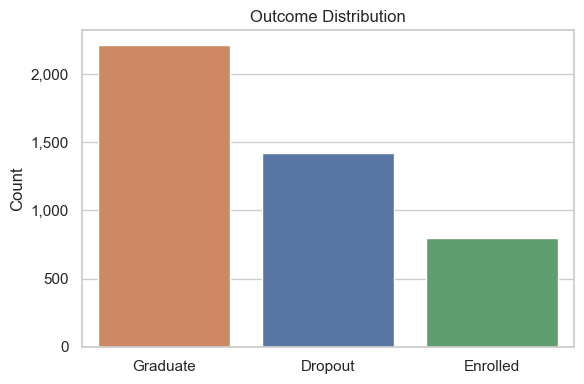

In [15]:
# # 1) Outcome distribution
fig, ax = plt.subplots(figsize=(6, 4))
labels = out_share.index
sns.countplot(x="Target", data=df, order=labels, ax=ax, hue="Target")
ax.set_title("Outcome Distribution")
ax.set_ylabel("Count")
ax.set_xlabel("")
ax.yaxis.set_major_formatter("{:,.0f}".format)
fig.tight_layout()
plt.show()

In [16]:
# Get whatever color palette the first plot used.
colors = [p.get_facecolor() for p in ax.patches]
palette = dict(zip(labels, colors, strict=False))

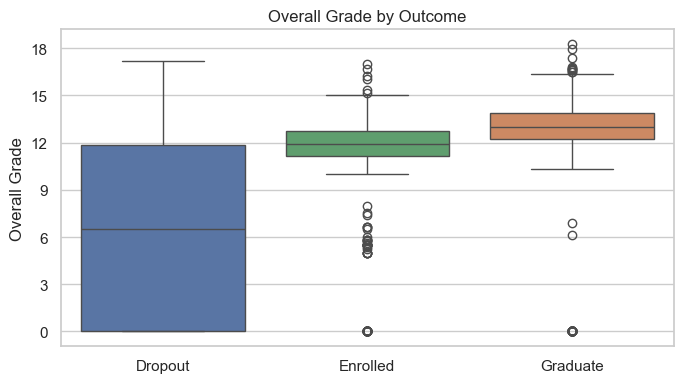

In [17]:
# 3) Overall grade by outcome (boxplot)
fig, ax = plt.subplots(figsize=(7, 4))
order = df.groupby("Target")["overall_grade"].median().sort_values().index
sns.boxplot(
    x="Target",
    y="overall_grade",
    data=df,
    order=order,
    # palette=palette,
    ax=ax,
    hue="Target",
)
ax.set_title("Overall Grade by Outcome")
ax.set_xlabel("")
ax.set_ylabel("Overall Grade")
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
fig.tight_layout()
plt.show()

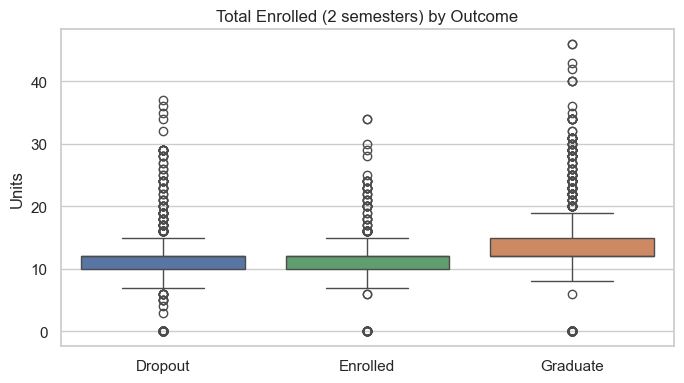

In [18]:
fig, ax = plt.subplots(figsize=(7, 4))
order = df.groupby("Target")["total_enrolled"].median().sort_values().index
sns.boxplot(x="Target", y="total_enrolled", data=df, order=order, ax=ax, hue="Target")
ax.set_title("Total Enrolled (2 semesters) by Outcome")
ax.set_xlabel("")
ax.set_ylabel("Units")
fig.tight_layout()
plt.show()

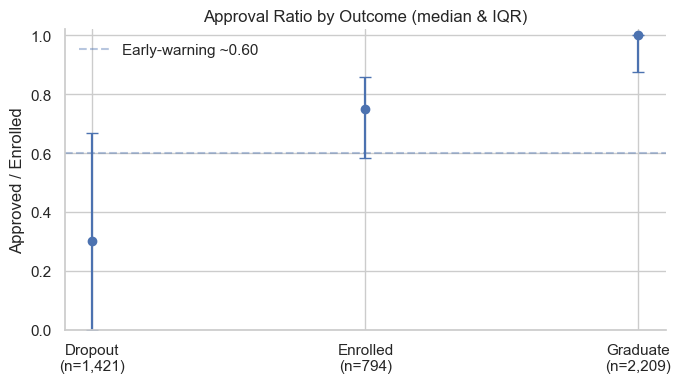

In [19]:
g = (
    df.groupby("Target")["approval_rate"]
    .agg(
        median="median",
        q1=lambda s: s.quantile(0.25),
        q3=lambda s: s.quantile(0.75),
        n="size",
    )
    .sort_values("median")
)

x = np.arange(len(g))
fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(
    x,
    g["median"],
    yerr=[g["median"] - g["q1"], g["q3"] - g["median"]],
    fmt="o",
    capsize=4,
    linewidth=1.6,
)
ax.axhline(0.60, ls="--", alpha=0.4, label="Early-warning ~0.60")
ax.set_xticks(x)
ax.set_xticklabels(
    [f"{k}\n(n={int(n):,})" for k, n in zip(g.index, g["n"], strict=False)]
)
ax.set_ylim(0, 1.02)
ax.set_ylabel("Approved / Enrolled")
ax.set_title("Approval Ratio by Outcome (median & IQR)")
ax.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.show()

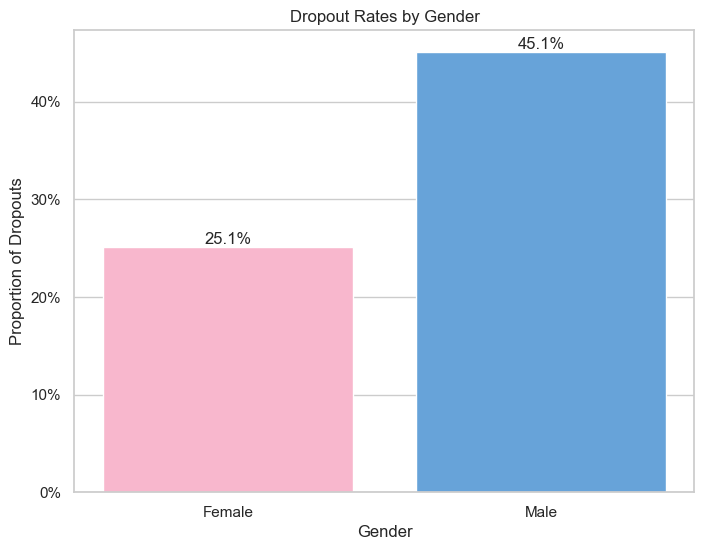

In [20]:
fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw={
        "title": "Dropout Rates by Gender",
        "xlabel": "Gender",
        "ylabel": "Proportion of Dropouts",
    },
)
drops_by_gender = (
    df_translated.groupby("Gender")["Target"]
    .value_counts(normalize=True)[(slice(None), "Dropout")]
    .sort_index()
)

bar_container = ax.bar(
    drops_by_gender.index, drops_by_gender.values, color=["#F8B7CD", "#67A3D9"]
)
ax.bar_label(bar_container, fmt="{:.1%}")
ax.grid(axis="x")
ax.yaxis.set_major_formatter("{:.0%}".format)

In [21]:
numeric_cols = [
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (without evaluations)",
    "Unemployment rate",
    "Inflation rate",
    "GDP",
    "total_enrolled",
    "total_approved",
    "approval_rate",
    "overall_grade",
]

df[numeric_cols].describe().round(1).T.astype({"count": int})

,count,mean,std,min,25%,50%,75%,max
Curricular units 1st sem (credited),4424,0.7,2.4,0.0,0.0,0.0,0.0,20.0
Curricular units 1st sem (enrolled),4424,6.3,2.5,0.0,5.0,6.0,7.0,26.0
Curricular units 1st sem (evaluations),4424,8.3,4.2,0.0,6.0,8.0,10.0,45.0
Curricular units 1st sem (approved),4424,4.7,3.1,0.0,3.0,5.0,6.0,26.0
Curricular units 1st sem (grade),4424,10.6,4.8,0.0,11.0,12.3,13.4,18.9
Curricular units 1st sem (without evaluations),4424,0.1,0.7,0.0,0.0,0.0,0.0,12.0
Curricular units 2nd sem (credited),4424,0.5,1.9,0.0,0.0,0.0,0.0,19.0
Curricular units 2nd sem (enrolled),4424,6.2,2.2,0.0,5.0,6.0,7.0,23.0
Curricular units 2nd sem (evaluations),4424,8.1,3.9,0.0,6.0,8.0,10.0,33.0
Curricular units 2nd sem (approved),4424,4.4,3.0,0.0,2.0,5.0,6.0,20.0


In [22]:
def format_heatmap_text(
    value: float, small_cutoff: float = 0.1, large_cutoff: float = 0.9
) -> str:
    if abs(value) in (0, 1):
        return f"{value:.0f}"
    elif abs(value) < small_cutoff or abs(value) > large_cutoff:
        return f"{value:.2f}"
    else:
        return f"{value:.1f}"

Text(0.5, 1.0, 'Complete Correlation Matrix')

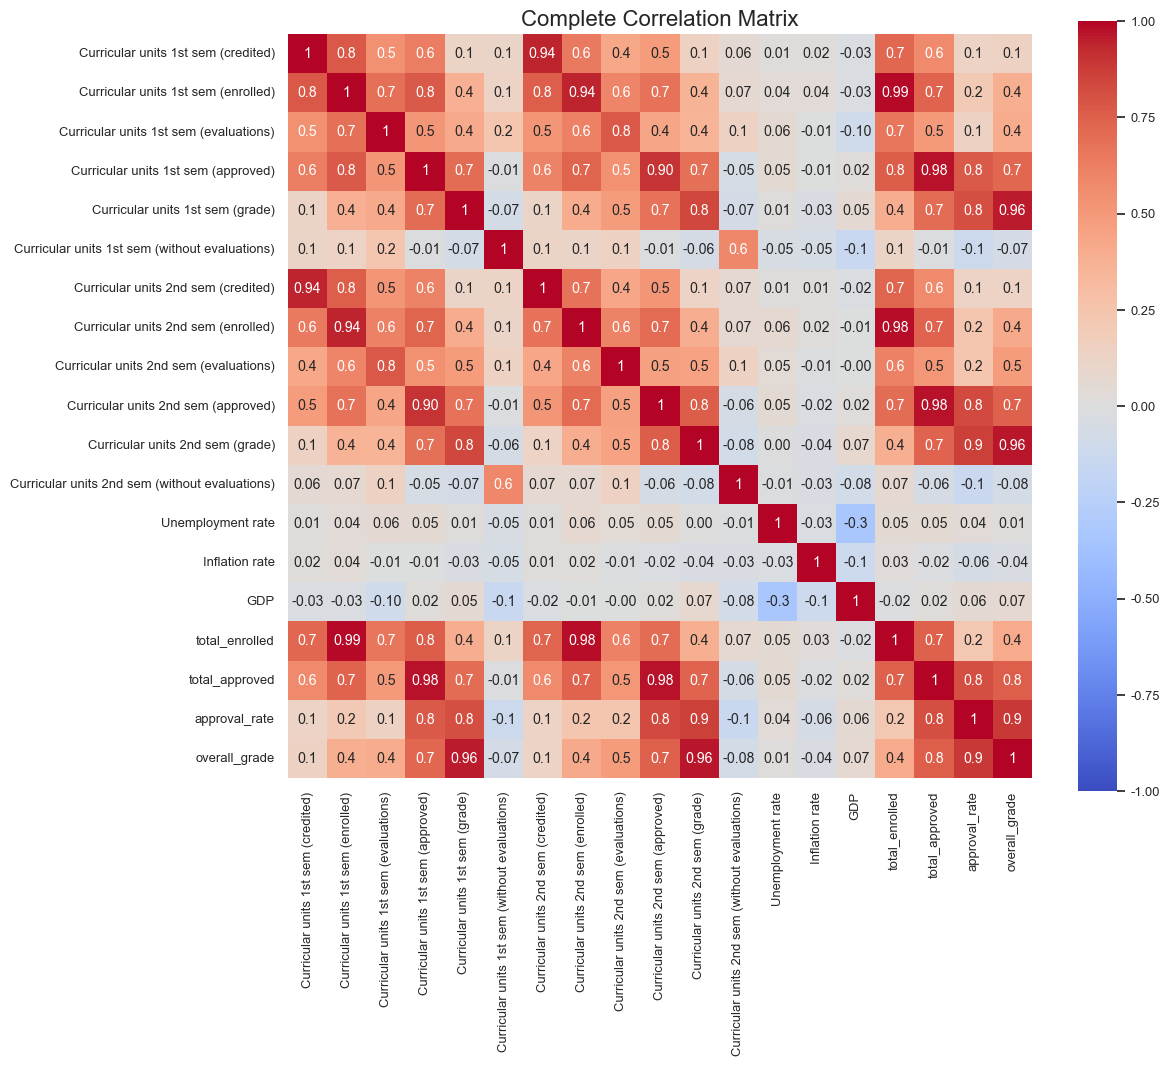

In [23]:
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.set(font_scale=0.85)
sns.heatmap(
    corr_matrix,
    annot=corr_matrix.map(format_heatmap_text),
    vmin=-1,
    cmap="coolwarm",
    fmt="",
    square=True,
    cbar_kws={"format": "%.2f"},
)
plt.title("Complete Correlation Matrix", fontsize=16)